In [ ]:
#install and import of necessary modules
!pip install erddapy
from erddapy import ERDDAP
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Dataset configurations
# Points to the MarineFlux ERDDAP server
datasets = {
    "ICOADS_COARE": {
        "id": "ICOADS_Fluxes_COARE",
        "server": "https://marineflux-erddap.coaps.fsu.edu/erddap",
    },
    "ICOADS_B23": {
        "id": "ICOADS_Fluxes_B23",
        "server": "https://marineflux-erddap.coaps.fsu.edu/erddap",
    },
    "ICOADS_S88": {
        "id": "ICOADS_Fluxes_S88",
        "server": "https://marineflux-erddap.coaps.fsu.edu/erddap",
    }
}

# Define time intervals. We use a short 1-year sample to keep things running quickly.
time_intervals = [(year, year + 1) for year in range(2006, 2008, 2)]

# Define axis limits for variables. Can be adjusted or new variables can be added
x_axis_ranges = {
    "shf": (-200, 300),
    "lhf": (-200, 300),
    "tau": (0, 0.6),
    "t_10": (-10, 40),
    "q_10": (0, 20),
    "Cd": (0.001, 0.0025),
    "Ce": (-0.002, 0.003),
    "Ch": (-0.002, 0.003),
    "u_star": (0, 0.8),
    "shf_qc": (1, 9),
    "lhf_qc": (1, 9),
    "tau_qc": (1, 9),
    "t_10_qc": (1, 9),
    "q_10_qc": (1, 9),
    "Cd_qc": (1, 9),
    "Ch_qc": (1, 9),
    "Ce_qc": (1, 9),
}

# Define flag variables for special binning
flag_variables = set([
    "shf_qc", "lhf_qc", "tau_qc", "t_10_qc", "q_10_qc",
    "Cd_qc", "Ce_qc", "Ch_qc"
])

# Define colors for each dataset
dataset_colors = {
    "ICOADS_COARE": "#D55E00",  # vermillion
    "ICOADS_B23": "#0072B2",    # blue
    "ICOADS_S88": "#009E73",    # bluish green
}


In [ ]:
# Function to fetch data. Can be used independently or in conjunction with plotting codes.
def fetch_data(dataset_name, variable, start_year, end_year):

    dataset = datasets[dataset_name]
    erddap = ERDDAP(server=dataset["server"], protocol="tabledap")
    erddap.dataset_id = dataset["id"]
    erddap.constraints = {
        "time>=": f"{start_year}-01-01T00:00:00Z",
        "time<=": f"{end_year}-12-31T23:59:59Z",
    }

    erddap.variables = [variable]
    try:
        ds = erddap.to_xarray(requests_kwargs={"timeout": 1800})
        print(f"Fetched data for {dataset_name} - {variable} ({start_year}-{end_year})")

        if variable in ds:
            data = ds[variable].values.flatten()
            data = data[~np.isnan(data)]
            return data if len(data) > 0 else None
        else:
            print(f"{variable} not found in {dataset_name} for {start_year}-{end_year}.")
            return None
    except Exception as e:
        print(f"Failed to fetch data for {dataset_name} - {variable} ({start_year}-{end_year}): {e}")
        return None


In [ ]:
#Function that fetches data and generates a histogram from it
def create_histogram(variable):
    for start_year, end_year in time_intervals:
        dataset_hist_data = {}
        all_data_combined = []

        for dataset_name in datasets.keys():
            data = fetch_data(dataset_name, variable, start_year, end_year)
            if data is not None:
                dataset_hist_data[dataset_name] = data
                all_data_combined.extend(data)

        if not dataset_hist_data:
            print(f"No valid data for {variable} in {start_year}-{end_year}. Skipping plot.")
            continue

        # Determine bins
        if variable in x_axis_ranges:
            lower_limit, upper_limit = x_axis_ranges[variable]
            if variable in flag_variables:
                bins = np.arange(lower_limit - 0.5, upper_limit + 1.5, 1)
            else:
                bins = np.linspace(lower_limit, upper_limit, 20)
        else:
            bin_range = (min(all_data_combined), max(all_data_combined))
            bins = np.linspace(bin_range[0], bin_range[1], 20)

        # Plot
        plt.figure(figsize=(12, 6))
        width = (bins[1] - bins[0]) / len(datasets)

        for i, (dataset_name, data) in enumerate(dataset_hist_data.items()):
            plt.bar(bins[:-1] + i * width, np.histogram(data, bins=bins)[0],
                    width=width, alpha=0.7, label=dataset_name, color=dataset_colors[dataset_name])

        plt.xlabel(variable, fontsize=14, fontweight="bold")
        plt.ylabel("Frequency", fontsize=14, fontweight="bold")
        plt.title(f"{start_year}-{end_year} Histogram of {variable}", fontsize=16, fontweight="bold")

        plt.grid(True, linestyle="--", alpha=0.6)
        plt.legend(fontsize=12)

        plt.show()

Fetched data for ICOADS_COARE - lhf (2006-2007)
Fetched data for ICOADS_B23 - lhf (2006-2007)
Fetched data for ICOADS_S88 - lhf (2006-2007)


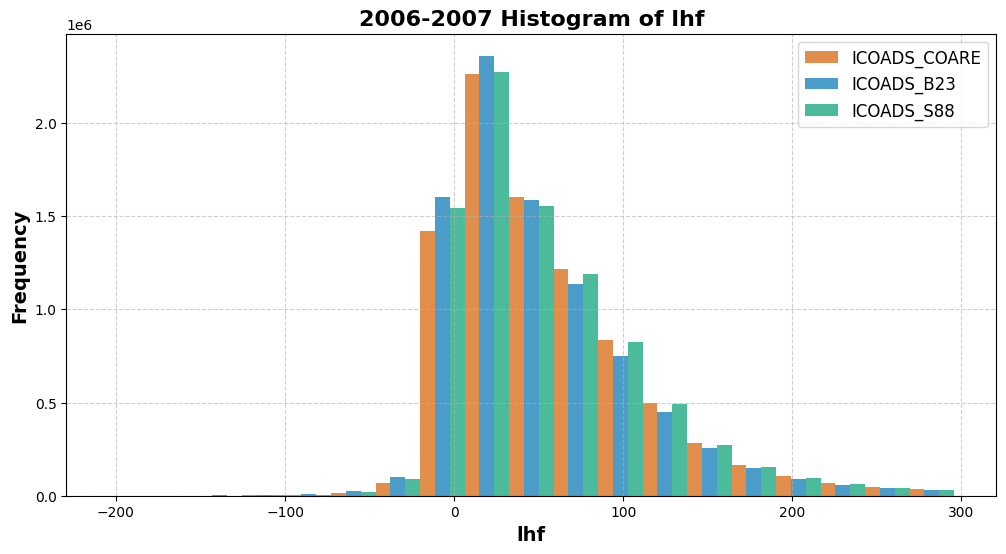

Fetched data for ICOADS_COARE - shf (2006-2007)
Fetched data for ICOADS_B23 - shf (2006-2007)
Fetched data for ICOADS_S88 - shf (2006-2007)


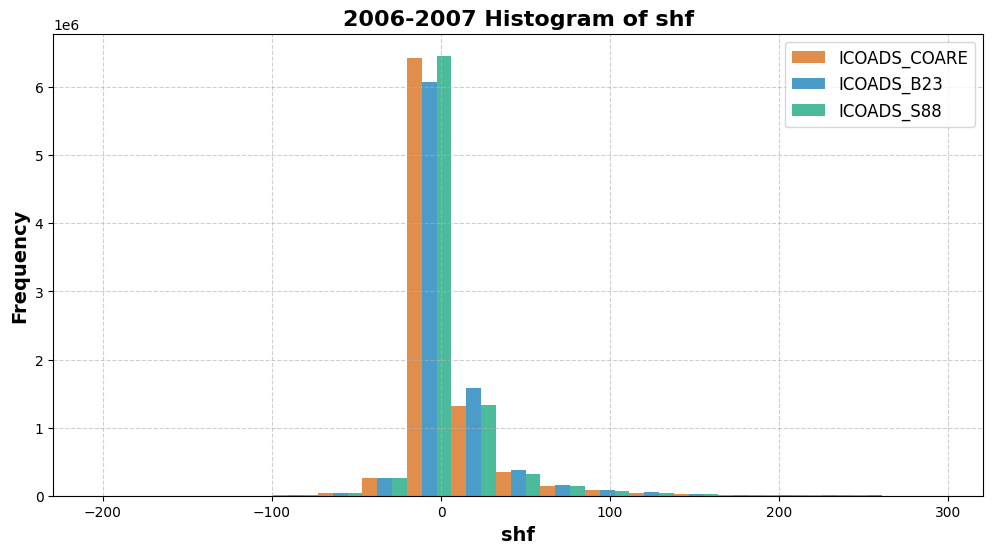

Fetched data for ICOADS_COARE - shf_qc (2006-2007)
Fetched data for ICOADS_B23 - shf_qc (2006-2007)
Fetched data for ICOADS_S88 - shf_qc (2006-2007)


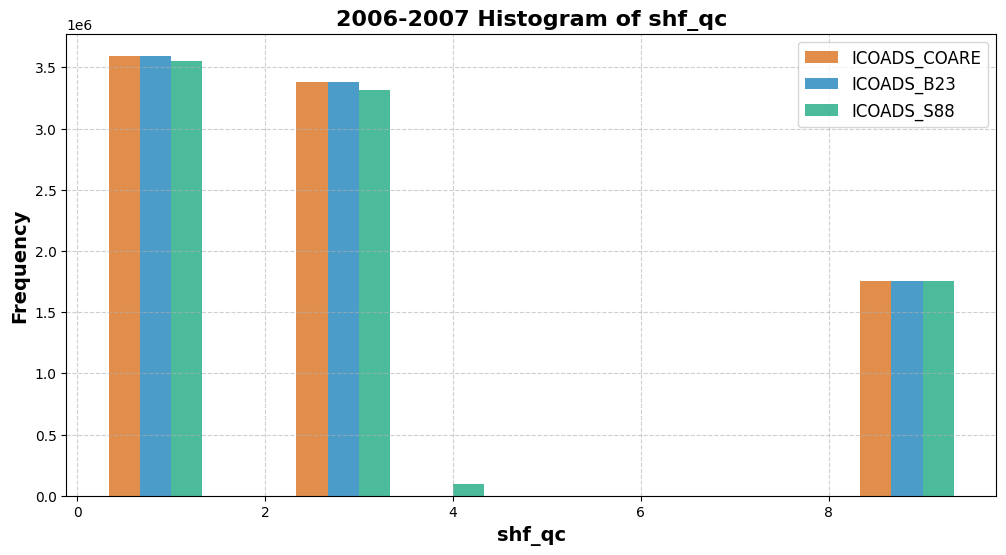

In [ ]:
'''
Variables to fetch and plot.
Any of the variables described in the x_axis_range can be added to the array and they will be
plotted with appropriate ranges below. Ranges and variables can be modified or added as needed.
'''

variables = {"shf", "lhf", "shf_qc"}

# Generate histograms
for variable in variables:
    create_histogram(variable)